In [1]:
import io
import base64

from dash import Dash, html, Input, Output, dcc
from jupyter_dash import JupyterDash
import matplotlib.pyplot as plt

import sys

import numpy as np
import matplotlib
#matplotlib.use("agg") # no GUI
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import hist.plot

sys.path.append("../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId


In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v33'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}

In [3]:
histStore.get(HistogramId("Clus3DSize", clueParams, "data")).getHistogram(HistogramKind.COUNT)

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  StrCategory(['allTracksters', 'mainTrackster'], name='mainOrAllTracksters', label='For 3D clusters, whether to consider for each event all 3D clusters (allTracksters) or only the highest energy 3D cluster (mainTrackster)'),
  Integer(1, 100, name='clus3D_size_custom', label='3D cluster size ie number of 2D clusters that make out this 3D cluster'),
  storage=Double()) # Sum: 620982.0

In [4]:
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1(children='CLUE3D cluster size'),
    #dcc.Dropdown(options=beamEnergies, value=100, id='beamEnergy', clearable=False),
    dcc.Slider(min=beamEnergies[0], max=beamEnergies[-1], step=None, 
        marks={beamEnergy:f"{beamEnergy} GeV" for beamEnergy in beamEnergies},
        id="beamEnergy", value=100),
    #dcc.Slider(min=1, max=28, step=1, value=5, id="layer"),
    dcc.RadioItems(options={"default" : "Default", "ratio" : "Ratio"}, value="default", inline=True, id="ratioPlot"),
    dcc.RadioItems(options=["mainTrackster", "allTracksters"], value="mainTrackster", inline=True, id="mainOrAllTracksters"),
    dcc.RadioItems(options=["Count", "Weight"], value="Count", inline=True, id="histogramKind"),
    html.Img(id="plot")
])

def loadHists(beamEnergy:int, datatypes:list[str], mainOrAllTracksters, kind) -> tuple[list[hist.Hist], list[str]]:
    return [(histStore
        .get(HistogramId("Clus3DSize", clueParams, datatype))
        .getHistogram(kind)[{
            "beamEnergy" : hist.loc(beamEnergy),
            "mainOrAllTracksters" : hist.loc(mainOrAllTracksters),
            #"layer" : hist.loc(layer),
        }]
        .project("clus3D_size_custom")
        ) for datatype in datatypes], [datatypeToLegendMap.get(datatype, datatype) for datatype in datatypes]

def addLumiLegend(main_ax, datatypes, beamEnergy):
    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    hep.cms.lumitext(f"$e^+$ {str(beamEnergy)} GeV", ax=main_ax)
    main_ax.legend()

def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

def makePlotMultiDatatype(beamEnergy:int, datatypes:list[str], mainOrAllTracksters, kind):
    """ Plot distribution of distance to impact on a layer 
    See in custom_hists for how y is computed"""
    hists, labels = loadHists(beamEnergy, datatypes, mainOrAllTracksters, kind=kind)
    yerr = False

    if kind is HistogramKind.COUNT: # Normalize MC to data counts
        for i in range(len(datatypes)):
            if i == 0:
                count_data = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
    
    #fig = plt.Figure()
    fig = plt.figure()
    ax = fig.subplots()
    #ax.set_xlabel("Distance to extrapolated impact point (cm)")
    ax.set_xlim(0, 6)
    
    #ax.set_ylabel(r"$\frac{1}{E_{cluster}} \frac{dE_{hit}}{dA} (cm^{-2})$")
    #ax.set_yscale("log")
    
    hep.histplot(hists, label=labels, yerr=yerr, ax=ax)

    ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("Number of layer cluster in a 3D cluster")
    ax.set_xlim(right=70)
    if kind is HistogramKind.COUNT:
        ax.set_ylabel("3D cluster count")
    elif kind is HistogramKind.WEIGHT:
        ax.set_ylabel("Sum of 3D cluster energies in each size bin (GeV)")

    addLumiLegend(ax, datatypes, beamEnergy)
    return fig


def mplFigureToUrl(fig=None):
    if fig is None:
        fig = plt.gcf()
    buf = io.BytesIO() # in-memory files
    fig.savefig(buf, format="png")
    plt.close(fig)
    data = base64.b64encode(buf.getbuffer()).decode("utf8") # encode to html elements
    buf.close()
    return "data:image/png;base64,{}".format(data)


@app.callback(
    Output(component_id='plot', component_property='src'),
    [Input(component_id = 'beamEnergy', component_property='value'),Input("ratioPlot", "value"),
    Input("mainOrAllTracksters", "value"), Input("histogramKind", "value")
    ]
)
def update_graph(beamEnergy, ratioPlot:bool, mainOrAllTracksters:str, histogramKind:str):
    if histogramKind == "Count":
        kind = HistogramKind.COUNT
    else:
        kind = HistogramKind.WEIGHT
    if ratioPlot == "ratio":
        pass
        #fig = makePlotRatio(layer, beamEnergy=beamEnergy, datatypes=["data", "sim_proton_v46_patchMIP"])
    else:
        fig = makePlotMultiDatatype(beamEnergy=beamEnergy, datatypes=["data", "sim_proton_v46_patchMIP"], mainOrAllTracksters=mainOrAllTracksters,
            kind=kind)
    return mplFigureToUrl(fig)


In [7]:
if __name__ == '__main__':
    #app.run_server(mode="inline")
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


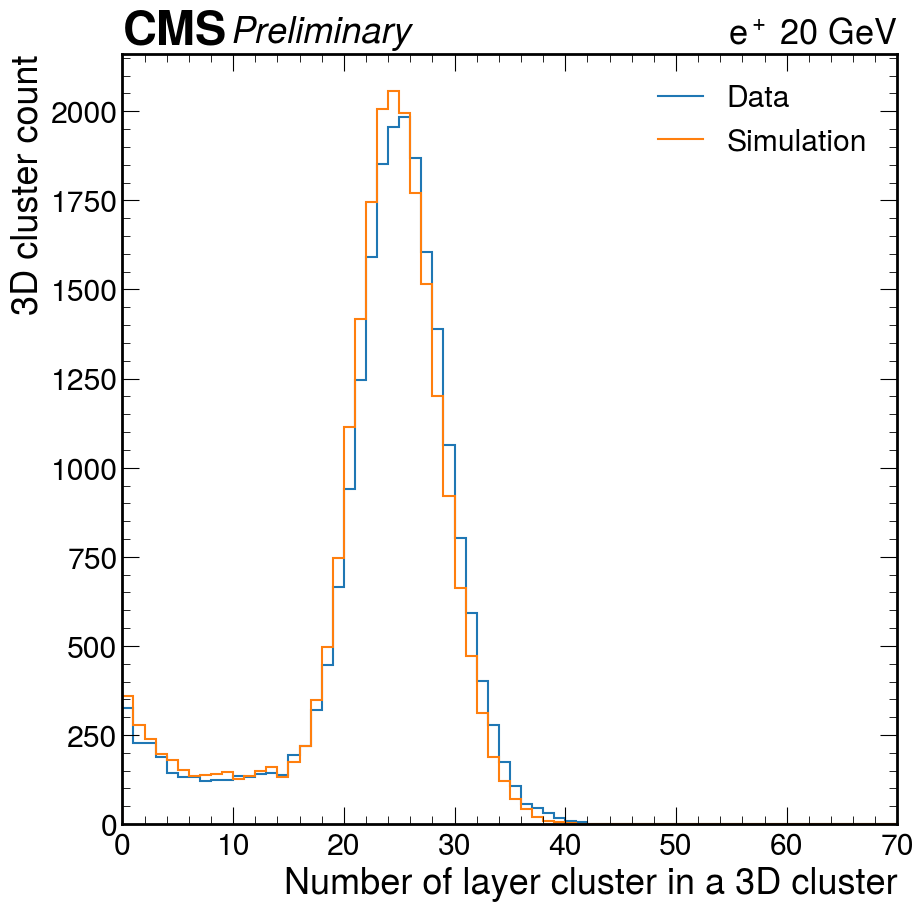

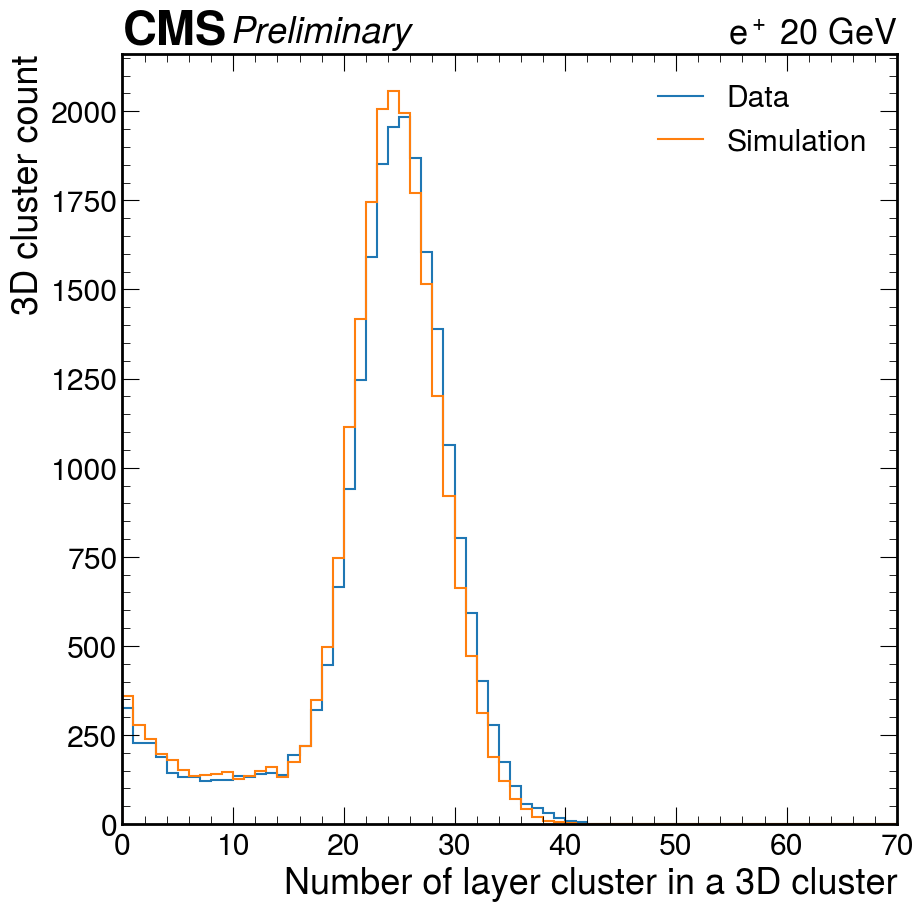

In [8]:
makePlotMultiDatatype(20, datatypes=["data", "sim_proton_v46_patchMIP"], mainOrAllTracksters="allTracksters",
            kind=HistogramKind.COUNT)